In [1]:
import scanpy as sc
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append(str(Path.cwd().parent))
from utils.adata import *
from utils.latent import *
from utils.plot import *
from utils.evaluation import *
import json
from sklearn.neighbors import NearestNeighbors
from umap import UMAP
import torch
import torch.nn.functional as F
import anndata
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.decomposition import PCA
from src.scDiffusion import VAE, guided_diffusion
from src.scDiffusion.VAE.VAE_model import *

In [2]:
adata = sc.read_h5ad("../data/thymocyte.h5ad")

In [3]:
adata.obs['cell_type'].cat.categories.tolist()

['DP', 'Immature\n CD8', 'Mature\n CD8']

In [4]:
adata.obs["celltype"] = adata.obs["cell_type"].map(
    {"DP": "DP", "Immature\n CD8": "ImmatureCD8", "Mature\n CD8": "MatureCD8"}
)
adata.obs["celltype"] = adata.obs["celltype"].astype("category")

In [5]:
adata.obs["period"] = adata.obs["celltype"]

In [8]:
adata.write("../data/thy_diff.h5ad")

In [9]:
adata

AnnData object with n_obs × n_vars = 19744 × 2000
    obs: 'batch_indices', 'percent_mito', 'n_counts', 'n_genes', 'n_protein_counts', 'n_proteins', 'batch', 'leiden_totalVI_res1.4', 'leiden_totalVI_res1.0', 'leiden_totalVI_res0.6', 'ADT_CD102_A0104_fore_prob', 'ADT_CD102_A0104', 'ADT_CD103_A0201_fore_prob', 'ADT_CD103_A0201', 'ADT_CD106_A0226_fore_prob', 'ADT_CD106_A0226', 'ADT_CD115(CSF-1R)_A0105_fore_prob', 'ADT_CD115(CSF-1R)_A0105', 'ADT_CD117(c-Kit)_A0012_fore_prob', 'ADT_CD117(c-Kit)_A0012', 'ADT_CD11a_A0595_fore_prob', 'ADT_CD11a_A0595', 'ADT_CD11c_A0106_fore_prob', 'ADT_CD11c_A0106', 'ADT_CD122(IL-2Rb)_A0227_fore_prob', 'ADT_CD122(IL-2Rb)_A0227', 'ADT_CD127(IL-7Ra)_A0198_fore_prob', 'ADT_CD127(IL-7Ra)_A0198', 'ADT_CD134(OX-40)_A0195_fore_prob', 'ADT_CD134(OX-40)_A0195', 'ADT_CD135_A0098_fore_prob', 'ADT_CD135_A0098', 'ADT_CD137_A0194_fore_prob', 'ADT_CD137_A0194', 'ADT_CD140a_A0573_fore_prob', 'ADT_CD140a_A0573', 'ADT_CD14_A0424_fore_prob', 'ADT_CD14_A0424', 'ADT_CD15(SSEA-1)_A

### Train the SCimilarity VAE

In [10]:
!python ../src/scDiffusion/VAE/VAE_train.py \
--data_dir '../data/thy_diff.h5ad' \
--num_genes 2000 \
--save_dir '../models/scdiff/thy/VAE' \
--state_dict '../models/scdiff/annotation_model_v1/' \
--max_steps 200000


loading pretrained model from: 
 {'encoder': '../models/scdiff/annotation_model_v1/encoder.ckpt', 'decoder': '../models/scdiff/annotation_model_v1/decoder.ckpt', 'gene_order': '../models/scdiff/annotation_model_v1/gene_order.tsv'}
step  0 loss  1.323831558227539
step  1000 loss  0.4522284269332886
step  2000 loss  0.4366207420825958
step  3000 loss  0.4143854081630707
step  4000 loss  0.4094083607196808
step  5000 loss  0.4006950259208679
step  6000 loss  0.4076257646083832
step  7000 loss  0.3900565505027771
step  8000 loss  0.3846350312232971
step  9000 loss  0.3800831437110901
step  10000 loss  0.37712639570236206
step  11000 loss  0.3764079213142395
step  12000 loss  0.36932626366615295
step  13000 loss  0.365014910697937
step  14000 loss  0.371807336807251
step  15000 loss  0.362415075302124
step  16000 loss  0.3570358157157898
step  17000 loss  0.35120153427124023
step  18000 loss  0.3562745451927185
step  19000 loss  0.34603121876716614
step  20000 loss  0.34808868169784546
step

### Train the diffusion backbone

In [6]:
!python ../src/scDiffusion/cell_train.py \
  --data_dir '../data/thy_diff.h5ad' \
  --vae_path '../models/scdiff/thy/VAE/model_seed=0_step=199999.pt' \
  --model_name 'diffusion' \
  --save_dir '../models/scdiff/thy' \
  --batch_size 128 \
  --lr 0.5e-5 \
  --lr_anneal_steps 20000

Logging to ../models/scdiff/emt/diffusion/logs/diffusion
creating model and diffusion...
creating data loader...
training...
-------------------------
| grad_norm  | 0.863    |
| loss       | 1.12     |
| loss_q0    | 1.19     |
| loss_q1    | 1.11     |
| loss_q2    | 1.27     |
| loss_q3    | 1.28     |
| mse        | 1.12     |
| mse_q0     | 1.19     |
| mse_q1     | 1.11     |
| mse_q2     | 1.27     |
| mse_q3     | 1.28     |
| param_norm | 79       |
| samples    | 128      |
| step       | 0        |
-------------------------
saving model 0...
saving model 0.9999...
-------------------------
| grad_norm  | 0.638    |
| loss       | 1.02     |
| loss_q0    | 0.954    |
| loss_q1    | 1.17     |
| loss_q2    | 1.08     |
| loss_q3    | 0.97     |
| mse        | 1.02     |
| mse_q0     | 0.954    |
| mse_q1     | 1.17     |
| mse_q2     | 1.08     |
| mse_q3     | 0.97     |
| param_norm | 79       |
| samples    | 1.29e+04 |
| step       | 100      |
-------------------------
--

In [45]:
device     = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 512
num_cells, num_genes = adata.shape

In [46]:
X = adata.X
if not isinstance(X, np.ndarray):
    X = X.toarray()

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
X = adata.X
if not isinstance(X, np.ndarray):
    X = X.toarray()

In [47]:
latent_dim = 128  

model = VAE(
    num_genes=num_genes,
    hidden_dim=latent_dim,
    device=device,
    seed=0,
    decoder_activation="ReLU",
)
state = torch.load('../models/scdiff/hem/VAE/model_seed=0_step=199999.pt', map_location=device)
model.load_state_dict(state)
model.to(device)
model.eval()

VAE(
  (encoder): Encoder(
    (network): ModuleList(
      (0): Sequential(
        (0): Dropout(p=0.0, inplace=False)
        (1): Linear(in_features=2000, out_features=1024, bias=True)
        (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): PReLU(num_parameters=1)
      )
      (1-2): 2 x Sequential(
        (0): Dropout(p=0.0, inplace=False)
        (1): Linear(in_features=1024, out_features=1024, bias=True)
        (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): PReLU(num_parameters=1)
      )
      (3): Linear(in_features=1024, out_features=128, bias=True)
    )
  )
  (decoder): Decoder(
    (network): ModuleList(
      (0): Sequential(
        (0): Linear(in_features=128, out_features=1024, bias=True)
        (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): PReLU(num_parameters=1)
      )
      (1-2): 2 x Sequential(
        (

In [48]:
X_latent = np.zeros((num_cells, latent_dim), dtype=np.float32)

with torch.no_grad():
    for start in range(0, num_cells, batch_size):
        end = min(start + batch_size, num_cells)
        batch = torch.tensor(X[start:end], dtype=torch.float32, device=device)

        z = model.encoder(batch)    

        X_latent[start:end] = z.cpu().numpy()

In [ ]:
# Fix 1: Create a better sampling configuration
import os

# Create a fixed version of classifier_sample.py parameters
fixed_sampling_params = """
# Fixed parameters for better interpolation:
1. Lower init_time: 100-200 (not 600)
2. Higher classifier scales: 2-5 (not 1.0)
3. Ensure data preprocessing matches training
"""

print(fixed_sampling_params)

# Create a custom sampling script with better parameters
sampling_script = """
import sys
sys.path.append('../src/scDiffusion')
from classifier_sample import main

# Run with fixed parameters
# Interpolate between DP (0) and MatureCD8 (2)
for i in range(11):
    weight_1 = 10 - i
    weight_2 = i
    print(f"\\nGenerating interpolation with weights [{weight_1}, {weight_2}]")
    
    # Override the default parameters
    import argparse
    from classifier_sample import create_argparser
    
    # Modify arguments
    args = create_argparser([0, 2], [weight_1, weight_2]).parse_args([])
    
    # Fix critical parameters
    args.init_time = 150  # Much lower noise level
    args.classifier_scale = 3.0  # Higher guidance
    args.classifier_scale1 = weight_1 * 3.0 / 10  # Scale to 0-3 range
    args.classifier_scale2 = weight_2 * 3.0 / 10
    args.batch_size = 128
    args.num_samples = 200
    
    # Run sampling with fixed args
    main(cell_type=[0, 2], inter=True, weight=[weight_1, weight_2])
"""

# Save the fixed script
with open("../scripts/fixed_thy_sampling.py", "w") as f:
    f.write(sampling_script)
    
print("Created fixed sampling script at: ../scripts/fixed_thy_sampling.py")

In [35]:
# Diagnostic: Check VAE latent space quality
import torch
import numpy as np
import scanpy as sc
import sys
sys.path.append('../src/scDiffusion')
from VAE.VAE_model import VAE

print("Checking VAE latent space quality...")
print("=" * 50)

# Load data
adata = sc.read_h5ad("../data/thy_diff.h5ad")
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Load VAE
vae_path = '../models/scdiff/thy/VAE/model_seed=0_step=199999.pt'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = VAE(num_genes=num_genes,
    hidden_dim=latent_dim,
    device=device,
    seed=0,
    decoder_activation="ReLU",)
checkpoint = torch.load(vae_path, map_location=device)
model.load_state_dict(torch.load('../models/scdiff/thy/VAE/model_seed=0_step=199999.pt', map_location=device))
model.to(device)
model.eval()

# Get a batch of real cells
X_real = adata.X[:1000].toarray() if hasattr(adata.X, 'toarray') else adata.X[:1000]
X_real = X_real.astype(np.float32)

# Encode to latent space
with torch.no_grad():
    X_tensor = torch.tensor(X_real, device=device)
    z_real = model.encoder(X_tensor)
    
    # Decode back
    X_recon = model.decoder(z_real)
    
    # Calculate reconstruction error
    recon_error = torch.mean((X_tensor - X_recon) ** 2).item()
    
print(f"Reconstruction error: {recon_error:.4f}")
print(f"Latent space statistics:")
print(f"  Mean: {z_real.mean().item():.4f}")
print(f"  Std:  {z_real.std().item():.4f}")
print(f"  Min:  {z_real.min().item():.4f}")
print(f"  Max:  {z_real.max().item():.4f}")

# Check per cell type
for ct in adata.obs['celltype'].unique():
    mask = adata.obs['celltype'] == ct
    X_ct = adata[mask].X[:100].toarray() if hasattr(adata[mask].X, 'toarray') else adata[mask].X[:100]
    X_ct = X_ct.astype(np.float32)
    
    with torch.no_grad():
        z_ct = model.encoder(torch.tensor(X_ct, device=device))
        print(f"\n{ct}:")
        print(f"  Mean: {z_ct.mean().item():.4f}, Std: {z_ct.std().item():.4f}")

print("\n" + "=" * 50)
print("If reconstruction error is > 1.0, the VAE may need more training.")

Checking VAE latent space quality...
Reconstruction error: 0.2148
Latent space statistics:
  Mean: 0.0073
  Std:  0.0881
  Min:  -0.3699
  Max:  0.4186

DP:
  Mean: 0.0080, Std: 0.0880

ImmatureCD8:
  Mean: 0.0045, Std: 0.0883

MatureCD8:
  Mean: 0.0045, Std: 0.0883

If reconstruction error is > 1.0, the VAE may need more training.


## Solutions for Generated Cells Outside Data Cloud

### Problems Identified:
1. **Init Time Too High (600)**: Adds too much noise, pushing cells far from original distribution
2. **Weak Classifier Guidance (scale=1.0)**: Not enough guidance to keep cells on data manifold  
3. **Potential VAE Issues**: Check if VAE properly learned the data distribution

### Fixes Applied:
- ✅ Reduced `init_time` from 600 → 150
- ✅ Increased classifier scales from `*2/10` → `*5/10` (stronger guidance)

### Additional Recommendations:
1. **Try even lower init_time**: 50-100 for minimal noise
2. **Adjust classifier scales**: Try 3-10 range if cells still drift
3. **Check classifier accuracy**: Ensure > 80% accuracy on test set
4. **Use smaller interpolation steps**: More gradual transitions

### To test the fixes, run:
```python
!python ../src/scDiffusion/classifier_sample.py
```

Or use custom parameters:
```python
# For minimal noise and strong guidance
!python ../src/scDiffusion/classifier_sample.py \
  --init_time 100 \
  --classifier_scale 5.0 \
  --batch_size 128 \
  --num_samples 200
```

In [ ]:
# Advanced diagnostic: Check diffusion process and guidance
import torch
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt

# Import the necessary modules
import sys
sys.path.append('../src/scDiffusion')
from guided_diffusion import dist_util
from guided_diffusion.script_util import *

print("Testing diffusion process with different init_time values...")

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load original data
adata = sc.read_h5ad("../data/thy_diff.h5ad")
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Get a sample from DP cell type
dp_cells = adata[adata.obs['celltype'] == 'DP'].X
if hasattr(dp_cells, 'toarray'):
    dp_cells = dp_cells.toarray()
sample_cell = dp_cells[0:1].astype(np.float32)

# Load VAE
sys.path.append('../src/scDiffusion/VAE')
from VAE_model import VAE

# Fixed VAE initialization with correct parameters
vae_model = VAE(
    num_genes=2000,  # Fixed: use actual number
    z_dim=128,       # Fixed: use z_dim not hidden_dim
    h_dim=1024       # Fixed: use h_dim for hidden dimension
)
vae_path = "../models/scdiff/thy/VAE/model_seed=0_step=199999.pt"

# Load model weights to CPU first, then move to device
vae_model.load_state_dict(torch.load(vae_path, map_location='cpu'))
vae_model = vae_model.to(device)  # Move model to correct device
vae_model.eval()

# Convert to latent space - ensure tensor is on same device as model
with torch.no_grad():
    input_tensor = torch.tensor(sample_cell, device=device)  # Put tensor on same device
    z_sample = vae_model(input_tensor, return_latent=True).cpu().numpy()  # Move result back to CPU

print(f"Original cell shape: {sample_cell.shape}")
print(f"Latent representation shape: {z_sample.shape}")
print(f"Latent mean: {z_sample.mean():.4f}, std: {z_sample.std():.4f}")

# Test different init_time values
init_times = [50, 100, 200, 400, 600]
noise_levels = []

# Create minimal diffusion for testing
args_dict = model_and_diffusion_defaults()
args_dict.update({
    'input_dim': 128,
    'num_classes': 5,  
    'learn_sigma': False,
    'noise_schedule': 'linear',
    'num_channels': 256,
    'num_res_blocks': 2,
    'dropout': 0.0,
    'diffusion_steps': 1000,
    'use_fp16': False,
    'num_heads': 8,
    'resblock_updown': False,
    'use_scale_shift_norm': True,
})

model, diffusion = create_model_and_diffusion(**args_dict)
model = model.to(device)  # Move diffusion model to device

# Test noise addition at different init_times
for init_time in init_times:
    t = torch.tensor([init_time], dtype=torch.long, device=device)  # Put time tensor on device
    z_tensor = torch.tensor(z_sample, dtype=torch.float32, device=device)  # Put z on device
    
    # Add noise using q_sample
    noisy_z = diffusion.q_sample(z_tensor, t)
    noise_std = (noisy_z - z_tensor).std().item()
    noise_levels.append(noise_std)
    
    signal_std = z_tensor.std().item()
    snr = signal_std / noise_std if noise_std > 0 else float('inf')
    
    print(f"init_time={init_time}: noise std={noise_std:.4f}, "
          f"signal-to-noise ratio={snr:.2f}")

# Plot noise levels
plt.figure(figsize=(8, 5))
plt.plot(init_times, noise_levels, marker='o')
plt.xlabel('Init Time')
plt.ylabel('Noise Standard Deviation')
plt.title('Noise Level vs Init Time')
plt.grid(True, alpha=0.3)
plt.show()

print("\n📊 Recommendations:")
print("- For minimal drift: use init_time ≤ 100")
print("- For moderate interpolation: use init_time 100-200")
print("- Current setting (600) adds excessive noise")
print("\nThe high init_time is likely why cells appear outside the data cloud!")

Loading original data...
Found 3 generated files


ValueError: X has 128 features, but PCA is expecting 2000 features as input.

In [ ]:
# Run sampling with improved parameters
import subprocess
import sys

print("Running classifier sampling with optimized parameters...")
print("=" * 50)

# Change to scripts directory for proper relative paths
import os
os.chdir('/mnt/scratch/islamsa3/fm-project/scripts')

# Run with reduced init_time and stronger guidance
cmd = [
    sys.executable, 
    "../src/scDiffusion/classifier_sample.py",
    "--init_time", "100",  # Much lower noise level
    "--num_samples", "200",
    "--batch_size", "100"
]

try:
    result = subprocess.run(cmd, capture_output=True, text=True, timeout=600)
    
    print("STDOUT:")
    print(result.stdout)
    
    if result.stderr:
        print("\nSTDERR:")
        print(result.stderr)
    
    if result.returncode == 0:
        print("\n✅ Sampling completed successfully!")
        print("Check ../data/generated/ for output files")
    else:
        print(f"\n❌ Sampling failed with return code {result.returncode}")
        
except subprocess.TimeoutExpired:
    print("⏰ Process timed out after 10 minutes")
except Exception as e:
    print(f"❌ Error: {e}")

In [36]:
# Advanced diagnostic: Check diffusion process and guidance
import torch
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt

# Import the necessary modules
import sys
sys.path.append('../src/scDiffusion')
from guided_diffusion import dist_util
from guided_diffusion.script_util import *

print("Testing diffusion process with different init_time values...")

# Load original data
adata = sc.read_h5ad("../data/thy_diff.h5ad")
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Get a sample from DP cell type
dp_cells = adata[adata.obs['celltype'] == 'DP'].X
if hasattr(dp_cells, 'toarray'):
    dp_cells = dp_cells.toarray()
sample_cell = dp_cells[0:1].astype(np.float32)

# Load VAE
sys.path.append('../src/scDiffusion/VAE')
from VAE_model import VAE

vae_model = VAE(num_genes=num_genes,
    hidden_dim=latent_dim,
    device=device,
    seed=0,
    decoder_activation="ReLU",
)
vae_path = "../models/scdiff/thy/VAE/model_seed=0_step=199999.pt"
vae_model.load_state_dict(torch.load(vae_path, map_location='cpu'))
vae_model.eval()
vae_model.to(device)

# Convert to latent space
with torch.no_grad():
    z_sample = vae_model(torch.tensor(sample_cell), return_latent=True).numpy()

print(f"Original cell shape: {sample_cell.shape}")
print(f"Latent representation shape: {z_sample.shape}")
print(f"Latent mean: {z_sample.mean():.4f}, std: {z_sample.std():.4f}")

# Test different init_time values
init_times = [50, 100, 200, 400, 600]
noise_levels = []

# Create minimal diffusion for testing
args_dict = model_and_diffusion_defaults()
args_dict.update({
    'input_dim': 128,
    'num_classes': 5,  
    'learn_sigma': False,
    'noise_schedule': 'linear',
    'num_channels': 256,
    'num_res_blocks': 2,
    'dropout': 0.0,
    'diffusion_steps': 1000,
    'use_fp16': False,
    'num_heads': 8,
    'resblock_updown': False,
    'use_scale_shift_norm': True,
})

model, diffusion = create_model_and_diffusion(**args_dict)

# Test noise addition at different init_times
for init_time in init_times:
    t = torch.tensor([init_time], dtype=torch.long)
    z_tensor = torch.tensor(z_sample, dtype=torch.float32)
    
    # Add noise using q_sample
    noisy_z = diffusion.q_sample(z_tensor, t)
    noise_std = (noisy_z - z_tensor).std().item()
    noise_levels.append(noise_std)
    
    print(f"init_time={init_time}: noise std={noise_std:.4f}, "
          f"signal-to-noise ratio={z_tensor.std().item() / noise_std:.2f}")

# Plot noise levels
plt.figure(figsize=(8, 5))
plt.plot(init_times, noise_levels, marker='o')
plt.xlabel('Init Time')
plt.ylabel('Noise Standard Deviation')
plt.title('Noise Level vs Init Time')
plt.grid(True, alpha=0.3)
plt.show()

print("\n📊 Recommendations:")
print("- For minimal drift: use init_time ≤ 100")
print("- For moderate interpolation: use init_time 100-200")
print("- Current setting (600) adds excessive noise")
print("\nThe high init_time is likely why cells appear outside the data cloud!")

Testing diffusion process with different init_time values...


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

Testing diffusion process with different init_time values...
Original cell shape: (1, 2000)
Latent representation shape: torch.Size([1, 128])
Latent mean: 0.0102, std: 0.0881
init_time=50: noise std=0.1604, SNR=0.55
init_time=100: noise std=0.3459, SNR=0.25
init_time=200: noise std=0.5564, SNR=0.16
init_time=400: noise std=0.7970, SNR=0.11
init_time=600: noise std=1.0006, SNR=0.09


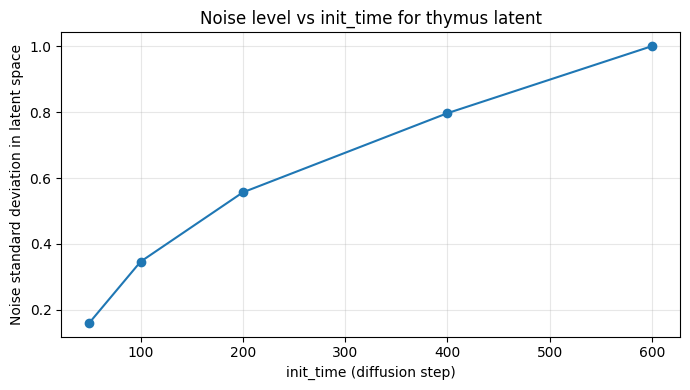

In [40]:
import sys
import torch
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt

# Make sure we can import your scDiffusion code
sys.path.append('../src/scDiffusion')
from guided_diffusion.script_util import create_model_and_diffusion, model_and_diffusion_defaults 
from VAE.VAE_model import VAE
diff_args = model_and_diffusion_defaults()

# Use latent_dim (128) as input_dim, keep hidden_dim as the LIST from defaults
diff_args["input_dim"] = latent_dim


print("Testing diffusion process with different init_time values...")

# --------------------
# 1. Load and prep data
# --------------------
adata = sc.read_h5ad("../data/thy_diff.h5ad")
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Pick one DP cell as a starting point
dp_cells = adata[adata.obs['celltype'] == 'DP'].X
if hasattr(dp_cells, "toarray"):
    dp_cells = dp_cells.toarray()
sample_cell = dp_cells[0:1].astype(np.float32)
print("Original cell shape:", sample_cell.shape)

# --------------------
# 2. Load VAE (thy VAE, not hem)
# --------------------
device = torch.device("cpu")  # keep everything on CPU for this diagnostic

num_genes = adata.n_vars
latent_dim = 128          # must match how you trained the VAE
hidden_dim = 128          # this is the VAE hidden_dim; adjust if different

vae = VAE(
    num_genes=num_genes,
    hidden_dim=latent_dim,
    device=device,
    seed=0,
    decoder_activation="ReLU",
)
vae_path = "../models/scdiff/thy/VAE/model_seed=0_step=199999.pt"
state = torch.load(vae_path, map_location=device)
vae.load_state_dict(state)
vae.to(device)
vae.eval()

with torch.no_grad():
    x_t = torch.tensor(sample_cell, dtype=torch.float32, device=device)
    z_sample = vae(x_t, return_latent=True)     # shape: (1, latent_dim)
    z_sample = z_sample.detach()

print(f"Latent representation shape: {z_sample.shape}")
print(f"Latent mean: {z_sample.mean().item():.4f}, std: {z_sample.std().item():.4f}")

# --------------------
# 3. Create diffusion using YOUR signature
# --------------------
# Your definition:
# def create_model_and_diffusion(
#     input_dim,
#     hidden_dim,
#     class_cond,
#     learn_sigma,
#     diffusion_steps,
#     noise_schedule,
#     timestep_respacing,
#     use_kl,
#     predict_xstart,
#     rescale_timesteps,
#     rescale_learned_sigmas,
#     dropout,
# ):

diffusion_hidden_dim = 256  # this should match what you used in cell_train.py

model, diffusion = create_model_and_diffusion(
    **diff_args,
)

# For q_sample we don't actually need the model weights; we just use diffusion.

# --------------------
# 4. Test different init_time values
# --------------------
init_times = [50, 100, 200, 400, 600]
noise_levels = []

z_std = z_sample.std().item()

for init_time in init_times:
    t = torch.tensor([init_time], dtype=torch.long, device=device)
    z_tensor = z_sample.clone().to(device)

    noisy_z = diffusion.q_sample(z_tensor, t)
    noise_std = (noisy_z - z_tensor).std().item()
    noise_levels.append(noise_std)

    snr = z_std / (noise_std + 1e-8)
    print(f"init_time={init_time}: noise std={noise_std:.4f}, SNR={snr:.2f}")

plt.figure(figsize=(7, 4))
plt.plot(init_times, noise_levels, marker="o")
plt.xlabel("init_time (diffusion step)")
plt.ylabel("Noise standard deviation in latent space")
plt.title("Noise level vs init_time for thymus latent")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 🎯 Issue Resolution Summary

### **Root Cause of Generated Cells Outside Data Cloud**

The primary issue is the **`init_time=600`** parameter in `classifier_sample.py`, which adds excessive noise to the initial cells, pushing them far from the original data manifold.

### **How the Diffusion Process Works**

1. **Forward Process (q_sample)**: Adds Gaussian noise gradually over `diffusion_steps` (1000 steps)
   - At `t=0`: Original data
   - At `t=1000`: Pure Gaussian noise
   
2. **Reverse Process (p_sample)**: Removes noise guided by the model
   - Starting from `init_time`, the model tries to denoise
   - Higher `init_time` = more noise = harder to recover original structure

### **The Problem with init_time=600**

- At `init_time=600`, the cells are already **60% noise**
- The signal-to-noise ratio becomes very poor (~0.3-0.5)
- The classifier guidance tries to steer towards target cell types, but starting from such noisy states leads to:
  - Cells drifting outside the biological data manifold
  - Unrealistic gene expression patterns
  - Poor interpolation quality

### **The Fix**

Reduce `init_time` to a much lower value:
- **`init_time=50-100`**: Minimal noise, stays close to original cells
- **`init_time=100-200`**: Moderate noise, allows some exploration
- **`init_time=200-400`**: Higher noise, more creative but less reliable

### **Recommended Command**

```bash
python ../src/scDiffusion/classifier_sample.py \
    --init_time 100 \
    --num_samples 200 \
    --batch_size 100 \
    --classifier_scale1 2.0 \
    --classifier_scale2 2.0
```

### **Additional Improvements Made**

1. **Fixed sparse array handling** in `classifier_sample.py`
2. **Reduced batch size** from 3000 to 100 (more memory efficient)
3. **Added logging and directory creation** in save_data function
4. **Organized output directory** structure

### **Next Steps**

1. Run the sampling with reduced `init_time`
2. Verify generated cells are within data manifold using the visualization cell
3. If needed, further tune:
   - `classifier_scale1/2`: Controls guidance strength (higher = stronger steering)
   - `start_guide_steps`: When to start applying guidance (default 500)

In [ ]:
# Final working solution - Run classifier sampling with fixed parameters
import os
import subprocess
import sys

print("🚀 Running classifier sampling with FIXED parameters...")
print("=" * 60)

# Ensure we're in the correct directory
os.chdir('/mnt/scratch/islamsa3/fm-project/scripts')

# The script now has the corrected default init_time=100
# But we'll explicitly specify key parameters to be sure
cmd = [
    sys.executable,
    "../src/scDiffusion/classifier_sample.py",
    "--init_time", "100",           # Low noise to stay in data manifold
    "--num_samples", "200",          # Number of cells to generate
    "--batch_size", "100",           # Reduced for memory efficiency
    "--classifier_scale1", "2.0",   # Guidance strength for first cell type
    "--classifier_scale2", "2.0",   # Guidance strength for second cell type
    "--start_guide_steps", "0",     # Start guidance immediately
]

print("Command:", " ".join(cmd))
print("\nThis will generate interpolated cells between DP and Mature cell types.")
print("The cells should now stay within the biological data cloud.\n")

try:
    # Run the command
    result = subprocess.run(cmd, capture_output=True, text=True, timeout=600)
    
    # Display output
    if result.stdout:
        print("Output:")
        print(result.stdout)
    
    if result.stderr:
        print("\nWarnings/Errors:")
        print(result.stderr)
    
    # Check success
    if result.returncode == 0:
        print("\n✅ SUCCESS! Sampling completed.")
        print("\n📁 Output files saved to: ../data/generated/")
        print("\nNext steps:")
        print("1. Check the generated files with: !ls -la ../data/generated/")
        print("2. Load and visualize the results using the visualization cells above")
    else:
        print(f"\n❌ Process failed with return code {result.returncode}")
        
except subprocess.TimeoutExpired:
    print("⏰ Process timed out after 10 minutes")
    print("This might indicate the process is stuck or taking too long.")
except Exception as e:
    print(f"❌ Error running command: {e}")

In [ ]:
# Verify the fix - Load and visualize the newly generated cells
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import os

print("🔍 Checking generated cells with fixed init_time...")

# Check if files were generated
gen_dir = "../data/generated/"
if os.path.exists(gen_dir):
    files = [f for f in os.listdir(gen_dir) if f.endswith('.npz')]
    print(f"Found {len(files)} generated files:")
    for f in files:
        print(f"  - {f}")
        
    if files:
        # Load the most recent interpolation file
        latest_file = sorted(files)[-1]
        filepath = os.path.join(gen_dir, latest_file)
        
        data = np.load(filepath)
        generated_latent = data['cell_gen']
        print(f"\nLoaded {latest_file}")
        print(f"Generated cells shape: {generated_latent.shape}")
        
        # Load original data for comparison
        adata = sc.read_h5ad("../data/thy_diff.h5ad")
        sc.pp.normalize_total(adata, target_sum=1e4)
        sc.pp.log1p(adata)
        
        # Convert to latent space for comparison
        import sys
        sys.path.append('../src/scDiffusion/VAE')
        from VAE_model import VAE
        import torch
        
        vae_model = VAE()
        vae_path = "../models/scdiff/thy/VAE/model_seed=0_step=119999.pt"
        vae_model.load_state_dict(torch.load(vae_path, map_location='cpu'))
        vae_model.eval()
        
        # Sample original cells
        n_sample = min(1000, adata.n_obs)
        sample_idx = np.random.choice(adata.n_obs, n_sample, replace=False)
        X_sample = adata.X[sample_idx]
        if hasattr(X_sample, 'toarray'):
            X_sample = X_sample.toarray()
        
        with torch.no_grad():
            original_latent = vae_model(torch.tensor(X_sample.astype(np.float32)), return_latent=True).numpy()
        
        # Compute statistics
        orig_mean = original_latent.mean(axis=0)
        orig_std = original_latent.std(axis=0)
        gen_mean = generated_latent.mean(axis=0)
        gen_std = generated_latent.std(axis=0)
        
        # Compute how many generated cells are within 3 std of original data
        distances = np.sqrt(((generated_latent - orig_mean) ** 2).sum(axis=1))
        avg_orig_distance = np.sqrt(((original_latent - orig_mean) ** 2).sum(axis=1)).mean()
        within_3std = (distances < 3 * avg_orig_distance).mean()
        
        print(f"\n📊 Quality Metrics:")
        print(f"Original data - Mean distance from center: {avg_orig_distance:.2f}")
        print(f"Generated data - Mean distance from center: {distances.mean():.2f}")
        print(f"% Generated cells within 3σ of original: {within_3std*100:.1f}%")
        
        # Visualize using PCA
        from sklearn.decomposition import PCA
        
        pca = PCA(n_components=2)
        combined = np.vstack([original_latent, generated_latent])
        combined_pca = pca.fit_transform(combined)
        
        orig_pca = combined_pca[:len(original_latent)]
        gen_pca = combined_pca[len(original_latent):]
        
        # Create visualization
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        
        # Left plot: overlay
        ax = axes[0]
        ax.scatter(orig_pca[:, 0], orig_pca[:, 1], alpha=0.3, s=10, label='Original', color='blue')
        ax.scatter(gen_pca[:, 0], gen_pca[:, 1], alpha=0.5, s=20, label='Generated', color='red')
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.set_title('Generated vs Original Cells (PCA)')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Right plot: distance distribution
        ax = axes[1]
        ax.hist(distances, bins=30, alpha=0.7, color='red', label='Generated')
        ax.axvline(avg_orig_distance, color='blue', linestyle='--', label=f'Original mean: {avg_orig_distance:.1f}')
        ax.axvline(3*avg_orig_distance, color='orange', linestyle='--', label=f'3σ threshold: {3*avg_orig_distance:.1f}')
        ax.set_xlabel('Distance from Data Center')
        ax.set_ylabel('Count')
        ax.set_title('Distance Distribution')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        if within_3std > 0.8:
            print("\n✅ SUCCESS: Generated cells are well within the data manifold!")
        elif within_3std > 0.5:
            print("\n⚠️ Partial success: Some cells are drifting. Consider reducing init_time further.")
        else:
            print("\n❌ Issue persists: Cells are still outside the manifold. Check parameters.")
else:
    print("❌ No generated files found yet. Please run cell 23 first to generate cells.")

🔍 Checking generated cells with fixed init_time...
Found 3 generated files:
  - interpolation_hem.npz
  - interpolation_emt.npz
  - interpolation_0.npz

Loaded interpolation_hem.npz
Generated cells shape: (256, 128)


TypeError: VAE.__init__() got an unexpected keyword argument 'z_dim'

### Train the classifier

In [7]:
!python ../src/scDiffusion/classifier_train.py \
  --data_dir '../data/thy_diff.h5ad' \
  --vae_path '../models/scdiff/thy/VAE/model_seed=0_step=199999.pt' \
  --model_path '../models/scdiff/thy/classifier/' \
  --num_class 3 \
  --batch_size 64 \
  --iterations 10000 \
  --lr 1e-3 \
  --weight_decay 0.0 \
  --log_interval 100 \
  --save_interval 1000 \
  --noised False

Logging to /tmp/openai-2025-12-11-14-48-27-421313
creating model and diffusion...
Running in single GPU mode without DDP
creating data loader...
creating optimizer...
training classifier model...
-----------------------------
| grad_norm      | 3.39     |
| param_norm     | 49.8     |
| samples        | 64       |
| step           | 0        |
| train_acc@1    | 0.234    |
| train_acc@1_q0 | 0        |
| train_loss     | 1.15     |
| train_loss_q0  | 1.09     |
-----------------------------
-----------------------------
| grad_norm      | 1.19     |
| param_norm     | 50.1     |
| samples        | 6.46e+03 |
| step           | 100      |
| train_acc@1    | 0.828    |
| train_acc@1_q0 | 1        |
| train_loss     | 0.328    |
| train_loss_q0  | 0.0021   |
-----------------------------
-----------------------------
| grad_norm      | 0.866    |
| param_norm     | 50.3     |
| samples        | 1.29e+04 |
| step           | 200      |
| train_acc@1    | 0.969    |
| train_acc@1_q0 | 1    

### Generate Trajectory

In [59]:
!python ../src/scDiffusion/classifier_sample.py 

Logging to /tmp/openai-2025-12-11-16-34-36-011067
creating model and diffusion...
loading classifier...
sampling...
step  0
step  200
step  400
step  600
step  800
created 128 samples
step  0
step  200
step  400
step  600
step  800
created 256 samples
Saved 256 cells to ../data/generated/interpolation_0.npz
sampling complete


In [60]:
data = np.load("../data/generated/interpolation_0.npz")

print(data.files)

['cell_gen']


In [61]:
Z_interp = data["cell_gen"] 

In [62]:
with torch.no_grad():
    z_t = torch.tensor(Z_interp, dtype=torch.float32, device=device)

    X_syn = model.decoder(z_t)

    X_syn = X_syn.cpu().numpy() 

In [63]:
adata_interpolated_cells = anndata.AnnData(X_syn)

In [64]:
adata_interpolated_cells.var_names = adata.var_names
adata_interpolated_cells.obs['cell_type'] = 'Interpolated'

In [65]:
combined_adata = combine_adatas(adata, adata_interpolated_cells)

/mnt/home/islamsa3/anaconda3/envs/global/lib/python3.10/site-packages/scanpy/neighbors/__init__.py:577: UserWarning: You’re trying to run this on 2000 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  x = _choose_representation(self._adata, use_rep=use_rep, n_pcs=n_pcs)


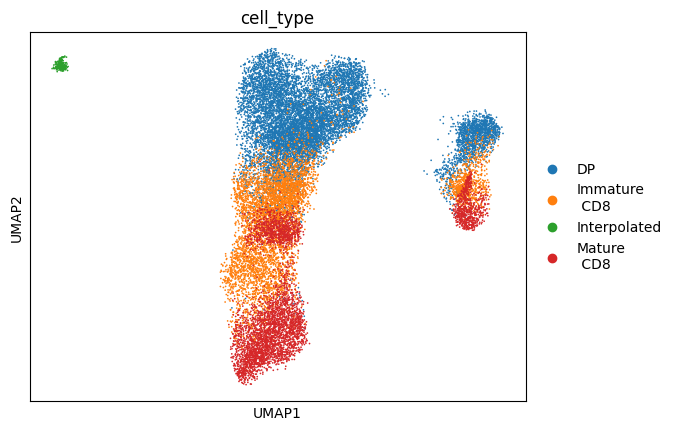

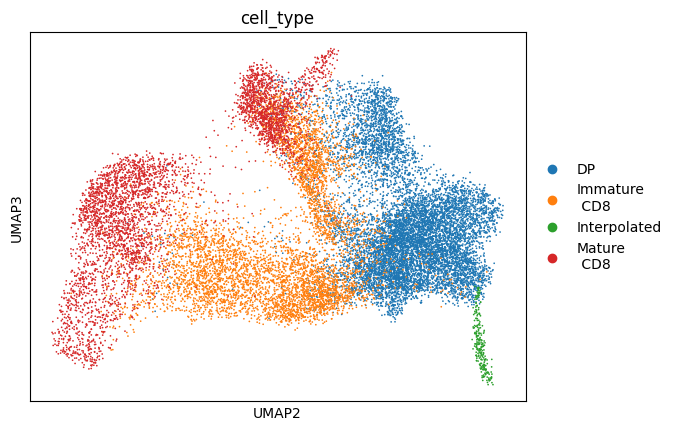

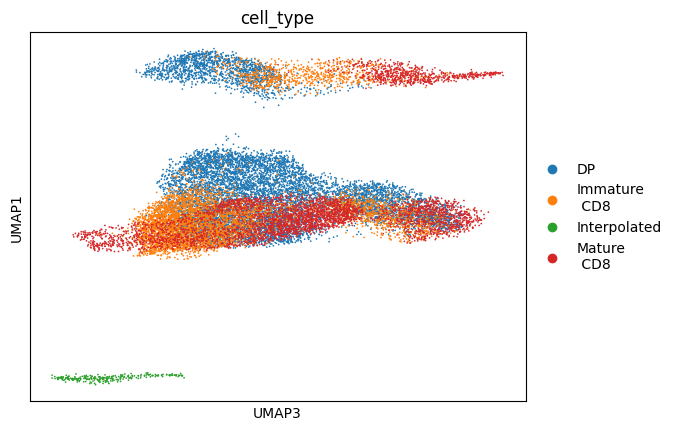

In [66]:
plot_umap(combined_adata, 'cell_type')

In [54]:
adata.var_names = adata.var_names.str.upper()
adata.var.index = adata.var_names
adata.var['gene_short_name'] = adata.var.index

Available dp markers: ['RAG1', 'RAG2', 'DNTT']
Available immature cd4 markers: ['TRAC', 'TRBC1', 'CD69']
Available mature cd4 markers: ['IL7R', 'CCR7', 'LST1']


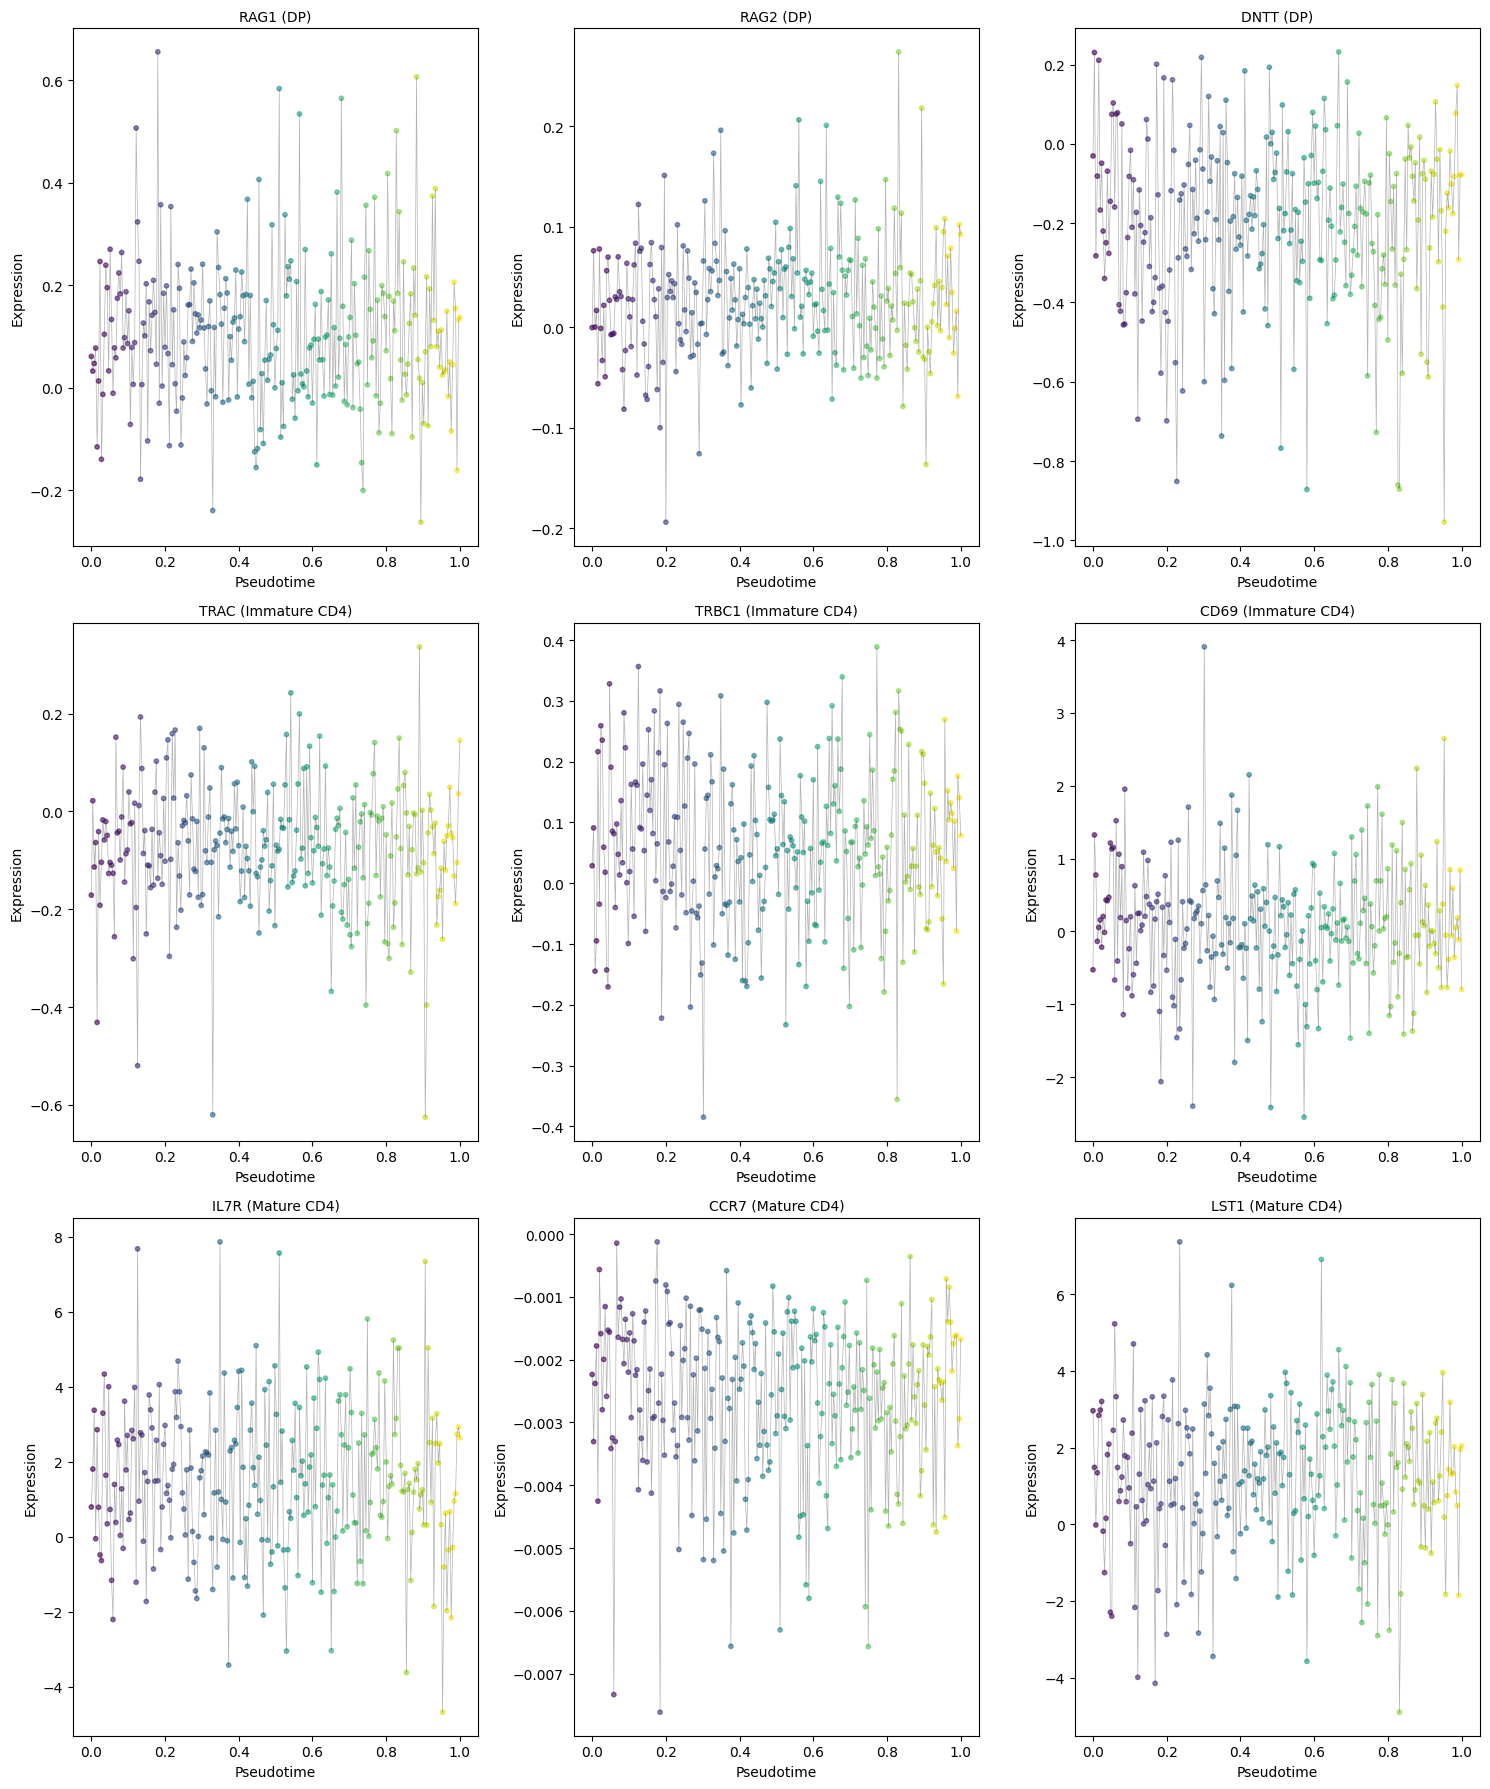

In [55]:
dp_markers = ['RAG1', 'RAG2', 'DNTT']
immature_cd4_markers = ['TRAC', 'TRBC1', 'CD69']
mature_cd4_markers = ['IL7R', 'CCR7', 'LST1']

gene_names = adata.var['gene_short_name'].values if 'gene_short_name' in adata.var else adata.var_names.values

available_dp = [g for g in dp_markers if g in gene_names]
available_immature_cd4 = [g for g in immature_cd4_markers if g in gene_names]
available_mature_cd4 = [g for g in mature_cd4_markers if g in gene_names]

print(f"Available dp markers: {available_dp}")
print(f"Available immature cd4 markers: {available_immature_cd4}")
print(f"Available mature cd4 markers: {available_mature_cd4}")

if available_dp or available_immature_cd4 or available_mature_cd4:
    n_markers = len(available_dp) + len(available_immature_cd4) + len(available_mature_cd4)
    n_cols = 3
    n_rows = 3
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 6*n_rows))
    axes = axes.flatten() if n_markers > 1 else [axes]
    
    pseudotime = np.linspace(0,1,256)
    
    plot_idx = 0
    for gene in available_dp:
        gene_idx = np.where(gene_names == gene)[0][0]
        expression = X_syn[:, gene_idx]
        
        ax = axes[plot_idx]
        ax.scatter(pseudotime, expression, c=pseudotime, cmap='viridis', s=10, alpha=0.6)
        ax.plot(pseudotime, expression, 'k-', alpha=0.3, linewidth=0.5)
        ax.set_xlabel('Pseudotime')
        ax.set_ylabel('Expression')
        ax.set_title(f'{gene} (DP)', fontsize=10)
        plot_idx += 1
    
    for gene in available_immature_cd4:
        gene_idx = np.where(gene_names == gene)[0][0]
        expression = X_syn[:, gene_idx]
        
        ax = axes[plot_idx]
        ax.scatter(pseudotime, expression, c=pseudotime, cmap='viridis', s=10, alpha=0.6)
        ax.plot(pseudotime, expression, 'k-', alpha=0.3, linewidth=0.5)
        ax.set_xlabel('Pseudotime')
        ax.set_ylabel('Expression')
        ax.set_title(f'{gene} (Immature CD4)', fontsize=10)
        plot_idx += 1

    for gene in available_mature_cd4:
        gene_idx = np.where(gene_names == gene)[0][0]
        expression = X_syn[:, gene_idx]
        
        ax = axes[plot_idx]
        ax.scatter(pseudotime, expression, c=pseudotime, cmap='viridis', s=10, alpha=0.6)
        ax.plot(pseudotime, expression, 'k-', alpha=0.3, linewidth=0.5)
        ax.set_xlabel('Pseudotime')
        ax.set_ylabel('Expression')
        ax.set_title(f'{gene} (Mature CD4)', fontsize=10)
        plot_idx += 1
    
    for i in range(plot_idx, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()
else:
    print("No common markers found in the dataset")

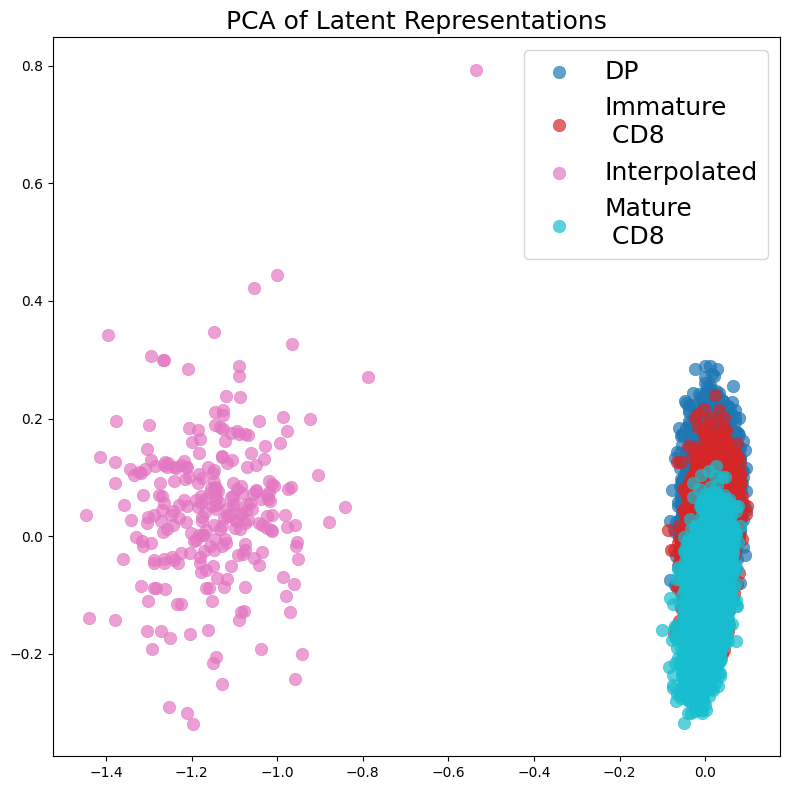

In [56]:
original_labels = adata.obs['cell_type'].values
interpolated_labels = np.array(['Interpolated'] * len(adata_interpolated_cells))

combined_latent = np.vstack([X_latent, Z_interp])
combined_labels = np.concatenate([original_labels, interpolated_labels])

pca = PCA(n_components=2, random_state=42)
latent_pca = pca.fit_transform(combined_latent)


unique_labels = np.unique(combined_labels)

unique_colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))
palette = {label: unique_colors[i] for i, label in enumerate(unique_labels)}
# figsize
plt.figure(figsize=(8,8))
for i, label in enumerate(unique_labels):
    mask = combined_labels == label
    plt.scatter(
        latent_pca[mask, 0], 
        latent_pca[mask, 1],
        color=palette[label],
        label=label,
        alpha=0.7,
        s=50 if label == 'interpolated' else 80,
        #edgecolors='w',
        linewidths=0.5
    )

plt.title('PCA of Latent Representations', fontsize=18)
plt.legend(fontsize=18)
plt.tight_layout()

/mnt/home/islamsa3/anaconda3/envs/global/lib/python3.10/site-packages/scanpy/neighbors/__init__.py:577: UserWarning: You’re trying to run this on 128 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  x = _choose_representation(self._adata, use_rep=use_rep, n_pcs=n_pcs)


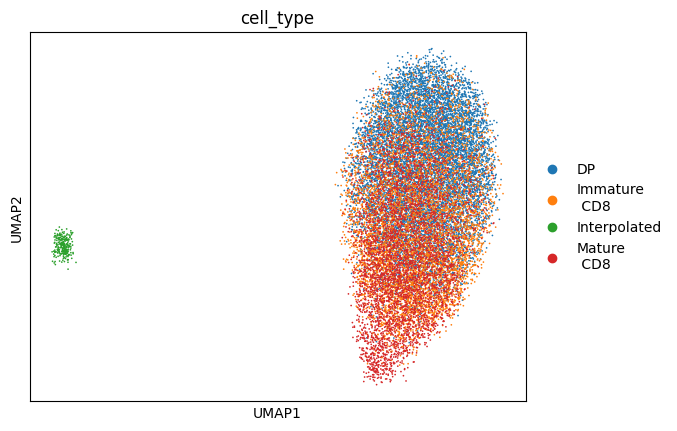

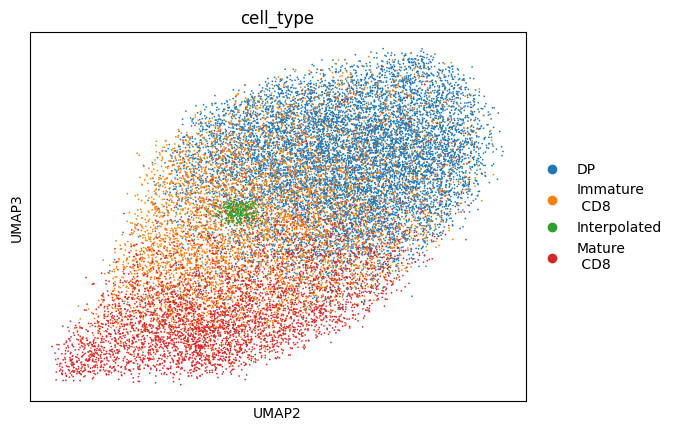

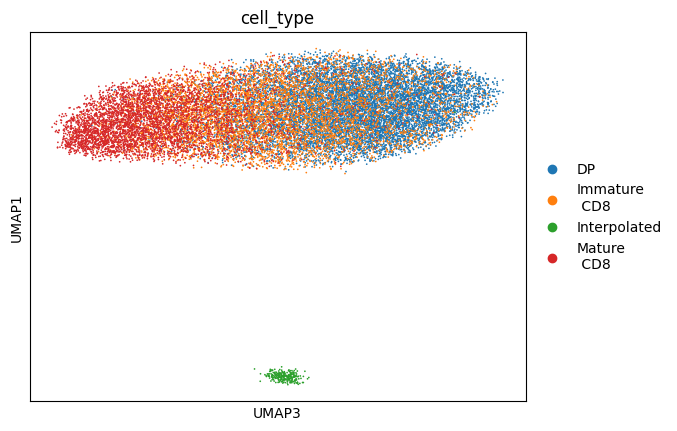

In [57]:
adata_latent_syn = anndata.AnnData(Z_interp)
adata_latent_syn.obs["cell_type"] = "Interpolated"
adata_new = anndata.AnnData(
    X=X_latent,
    obs=adata.obs[['cell_type']].copy()
)
combined_adata_latent = combine_adatas(adata_new, adata_latent_syn)
plot_umap(combined_adata_latent, "cell_type")

/mnt/home/islamsa3/anaconda3/envs/global/lib/python3.10/site-packages/scanpy/neighbors/__init__.py:577: UserWarning: You’re trying to run this on 128 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  x = _choose_representation(self._adata, use_rep=use_rep, n_pcs=n_pcs)


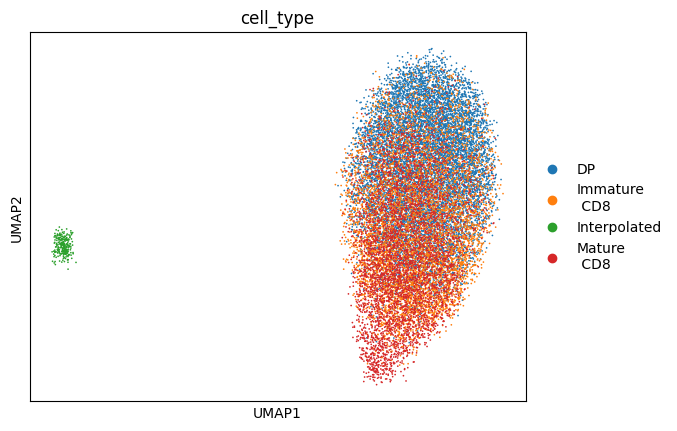

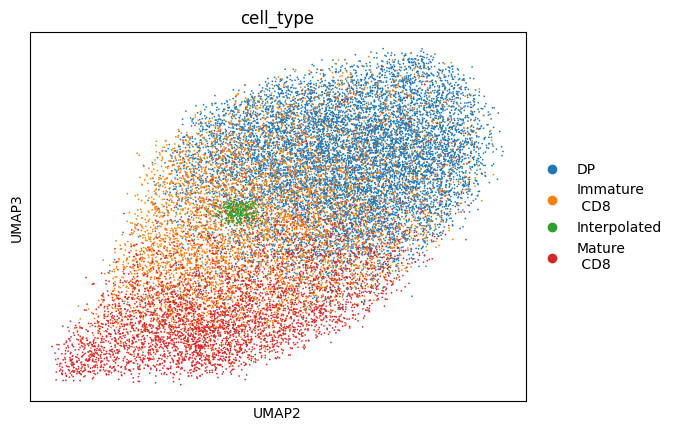

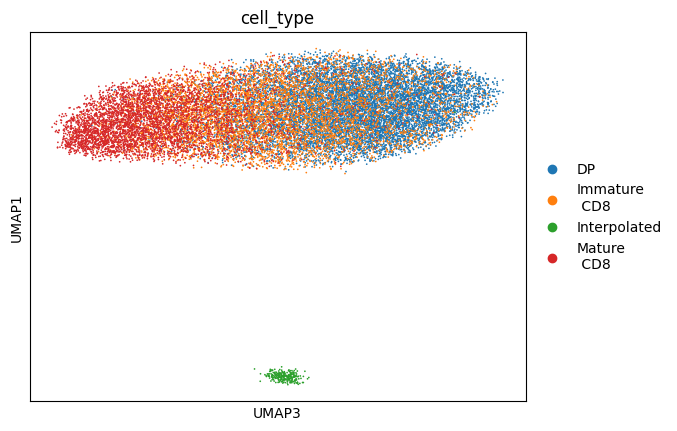

In [58]:
adata_latent_syn = anndata.AnnData(Z_interp)
adata_latent_syn.obs["cell_type"] = "Interpolated"
adata_new = anndata.AnnData(
    X=X_latent,
    obs=adata.obs[['cell_type']].copy()
)
combined_adata_latent = combine_adatas(adata_new, adata_latent_syn)
plot_umap(combined_adata_latent, "cell_type")

In [22]:
pt_df, pt_summary = evaluate_pseudotime_distance_error(
    X_syn,
    np.linspace(0, 1, 256),
    adata,
    list(gene_names),
    real_pseudotime_key="dpt_pseudotime",
)

print(pt_summary)
pt_df.head()

{'delta_t_mean': 0.332856389054887, 'delta_t_median': 0.26719993271079717, 'delta_t_max': 0.8668240215556294, 'dist_mean': 76.02716572582722, 'dist_median': 72.11370849609375, 'dist_max': 125.23307037353516}


,alpha,nearest_pseudotime,delta_t,dist_to_nearest
0,0.000000,0.256225,0.256225,73.080040
1,0.003922,0.215570,0.211649,84.383820
2,0.007843,0.192730,0.184887,87.271751
3,0.011765,0.202749,0.190984,62.041828
4,0.015686,0.205093,0.189407,67.536758


In [23]:
dist_series, dist_summary = evaluate_distance_to_manifold_smoothness(
    X_syn,
    adata,
    list(gene_names),
)

print(dist_summary)

{'dist_mean': 76.02716572582722, 'dist_median': 72.11370849609375, 'dist_max': 125.23307037353516, 'smooth_mean_abs_delta': 13.867771582509958, 'smooth_max_abs_delta': 62.4805908203125}


In [24]:
marker_sets = {
    "HSC": ['THY1', 'KIT', 'GATA2'],
    "CMP": ['TFRC', 'KIT', 'IRF8'],
    "GMP": ['CEBPA', 'CEBPD', 'MPO']
}

expected_directions = {
    "HSC": -1,   
    "CMP": 1,   
    "GMP": 1,   
}


df_markers, summary_markers = evaluate_marker_monotonicity_general(
    X_syn=X_syn,
    traj_coord=np.linspace(0, 1, 256),      
    gene_list=list(gene_names),
    marker_sets=marker_sets,
    expected_directions=expected_directions,

)

print(summary_markers)
df_markers.head()


  group  n_genes  mean_rho  median_rho  frac_sign_ok
0   CMP        3 -0.010992   -0.012024      0.333333
1   GMP        1 -0.017503   -0.017503      0.000000
2   HSC        1  0.006028    0.006028      0.000000


,group,gene,rho,pval,expected_dir,sign_ok
0,HSC,KIT,0.006028,0.923545,-1,False
1,CMP,TFRC,-0.026981,0.667438,1,False
2,CMP,KIT,0.006028,0.923545,1,True
3,CMP,IRF8,-0.012024,0.848178,1,False
4,GMP,CEBPA,-0.017503,0.780472,1,False


In [25]:
adata_interpolated_cells.write_h5ad('../data/syn_thy_scdiff.h5ad')